## Python Lottery Dataset Analyze

Jupyter's notebook illustrating several methods for analyzing a dataset with the historical results of various lotteries.
The example shows how to analyze the linear correlation between individual fields, using the extension of the result set with astronomical data, and shows how to visualize the distribution of numbers at individual positions.

(c) 2022 Marcin "szczyglis" Szczygliński

GitHub page: https://github.com/szczyglis-dev/python-lottery-dataset-analyze

Email: szczyglis@protonmail.com

Version: 1.0.0

This package is licensed under the MIT License.

License text available at https://opensource.org/licenses/MIT

In [1]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install scipy
!pip install skyfield

**1. Configuration, initialization and modules import.**

Historical drawing results for several popular number lotteries in Poland will be used as input data. The results of the draws will be downloaded to CSV files and saved in a local directory on the disk. The block includes the configuration for each of these lotteries, such as the names of the columns that will be used later in the DataFrame object created from the data set, ranges of numbers, and the format in which the individual drawing dates are saved. At the end of the block, specify the name of the lottery for which the data will be analyzed. The block will also load astronomical data for several celestial bodies, which will then be used to extend the data set with the distances between individual celestial bodies during a given draw. This will be used to test the correlation between these events/variables.

In [2]:
import os
import math
from datetime import datetime
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from skyfield.api import load

# define URLs with lotteries historical results in CSV
csv_urls = {
    'lotto': 'https://www.wynikilotto.net.pl/download/lotto.csv',
    'lotto_plus': 'https://www.wynikilotto.net.pl/download/lotto_plus.csv',
    'eurojackpot': 'https://www.wynikilotto.net.pl/download/eurojackpot.csv',
    'minilotto': 'https://www.wynikilotto.net.pl/download/mini_lotto.csv',
    'multi': 'https://www.wynikilotto.net.pl/download/multi_multi.csv'    
}

# [CSV config]
# headers - array with CSV column names
#   idx - number of record
#   date - date field
#   n(x) - primary number(x) field
#   m(x) - secondary number(x) field
# n_range - array with primary numbers range [from, to]
# m_range - array with secondary numbers range [from, to]
# n_count - number of primary numbers
# m_count - secondary of primary numbers
# date_format - date field string format

csv_config = {
    'lotto': {        
        'headers': ['idx', 'date', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6'],
        'n_range': [1, 49],
        'm_range': [],
        'n_count': 6,
        'm_count': 0,
        'date_format': '%d.%m.%Y'
    },
    'lotto_plus': {
        'headers': ['idx', 'date', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6'],
        'n_range': [1, 49],
        'm_range': [],
        'n_count': 6,
        'm_count': 0,
        'date_format': '%d.%m.%Y'
    },
    'eurojackpot': {
        'headers': ['idx', 'date', 'n1', 'n2', 'n3', 'n4', 'n5', 'm1', 'm2'],
        'n_range': [1, 50],
        'm_range': [1, 12],
        'n_count': 5,
        'm_count': 2,
        'date_format': '%d.%m.%Y'
    },
    'minilotto': {
        'headers': ['idx', 'date', 'n1', 'n2', 'n3', 'n4', 'n5'],
        'n_range': [1, 42],
        'm_range': [],
        'n_count': 5,
        'm_count': 0,
        'date_format': '%d.%m.%Y'
    },
    'multi': {
        'headers': ['idx', 'date', 'time', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 
                    'n10', 'n11', 'n12', 'n13', 'n14', 'n15', 'n16', 'n17', 'n18', 'n19', 'n20', 'x1'],
        'n_range': [1, 80],
        'm_range': [1, 80],
        'n_count': 20,
        'm_count': 1,
        'date_format': '%d.%m.%Y'
    }
}

# specify download dir for CSV files
csv_dir = './csv'

# choose lottery
lottery = 'lotto'

# init astronomical data
planets = load('de421.bsp')
earth, moon, sun, mars = planets['earth'], planets['moon'], planets['sun'], planets['mars']  

[#################################] 100% de421.bsp


**2. Functions definitions.**

The following cell defines the functions that will be used in subsequent blocks. Functions include downloading and saving the data set to CSV and extending the downloaded data set with new values that will then be used for further analysis.

In [3]:
# create directory for CSV download if not exists
def csv_dir_create(csv_dir):
    pwd = os.getcwd()
    csv_path = os.path.join(pwd, csv_dir)
    if not os.path.exists(csv_path):
        os.makedirs(csv_path)
        

# download and save CSV dataset
def csv_update(csv_urls, csv_dir):
    for k, url in csv_urls.items():
        r = requests.get(url, allow_redirects=True)
        name = k + '.csv'
        fname = os.path.join(csv_dir, name)
        open(fname, 'wb').write(r.content)
        print('Downloaded: ' + fname)
        
        
# load CSV dataset        
def csv_load(name, headers):
    pwd = os.getcwd()
    file = os.path.join(pwd, 'csv', name+'.csv')
    return pd.read_csv(file, header=None, names=headers)


# save dataframe to CSV file
def csv_save(df, name):
    pwd = os.getcwd()
    file = os.path.join(pwd, 'csv', name+'.csv')
    df.to_csv(file, index=False) 
    

# append date part to series
def df_append_date_part(part, row, dt_format):
    dt = datetime.strptime(row.date, dt_format)
    return int(dt.strftime(part))


# get date parts
def df_get_date_parts(row, dt_format):
    dt = datetime.strptime(row.date, dt_format)
    y = int(dt.strftime('%Y'))
    m = int(dt.strftime('%m'))
    d = int(dt.strftime('%d'))
    return y, m, d


# append astro planets distance to series
def df_append_astro_distance(obj1, obj2, row, dt_format):
    ts = load.timescale() 
    y, m, d = df_get_date_parts(row, dt_format)
    t = ts.utc(y, m, d, 9, 0) 
    return obj1.at(t).observe(obj2).apparent().distance().au


# append numbers ranges to series
def df_append_range(row, num_idx):
    j = 10;
    while j <= 100:
        if row[num_idx] >= (j - 10) and row[num_idx] < j:
            return int((j - 10)/10)
        j+= 10

**3. Download CSV files with data sets.**

The cell below will download result sets to CSV files. In order not to download new data and to use only those already downloaded, this block should be commented out.

In [4]:
print('Downloading datasets....')
      
csv_dir_create(csv_dir)
csv_update(csv_urls, csv_dir)

Downloaded: ./csv/lotto.csv
Downloaded: ./csv/lotto_plus.csv
Downloaded: ./csv/eurojackpot.csv
Downloaded: ./csv/minilotto.csv
Downloaded: ./csv/multi.csv


**4. Extend the result set with additional fields.**

The following code expands the result set with new fields. Numerical values for the saved draw dates will be added to it, such as: year, month, day, day of the week and day of the year. In addition, the distances to individual celestial bodies (Earth - Moon, Earth - Sun, Earth - Mars) that occurred during each of the draws will be calculated and attached to the set. The set will also include fields that define the range of numbers at a given position.

In [5]:
# get CSV config for selected lottery
cfg = csv_config[lottery]
dt_format = cfg['date_format']
headers = cfg['headers']

# load CSV dataset and create dataframe from it
df = csv_load(lottery, headers)

# append date parts as integers
df['year'] = df.apply(lambda row: df_append_date_part('%Y', row, dt_format), axis=1)
df['month'] = df.apply(lambda row: df_append_date_part('%m', row, dt_format), axis=1)
df['day'] = df.apply(lambda row: df_append_date_part('%d', row, dt_format), axis=1)
df['day_of_week'] = df.apply(lambda row: df_append_date_part('%w', row, dt_format), axis=1)
df['day_of_year'] = df.apply(lambda row: df_append_date_part('%j', row, dt_format), axis=1)

# append distances from earth to moon, sun & mars
df['dist_moon_au'] = df.apply(lambda row: df_append_astro_distance(earth, moon, row, dt_format), axis=1)
df['dist_sun_au'] = df.apply(lambda row: df_append_astro_distance(earth, sun, row, dt_format), axis=1)
df['dist_mars_au'] = df.apply(lambda row: df_append_astro_distance(earth, mars, row, dt_format), axis=1)

# append decimal ranges of numbers to rn1-rn(i) fields that corresponds numbers on positions n1-n(i)
limit = cfg['n_count']
if limit > 0:
    for i in range(1, limit):
        range_field = 'n' + str(i) + 'r'
        num_field = 'n' + str(i)           
        df[range_field] = df.apply(lambda row: df_append_range(row, num_field), axis=1)

# append decimal ranges of numbers to rm1-rm(i) fields that corresponds numbers on positions m1-m(i)
limit = cfg['m_count']
if limit > 0:
    for i in range(1, limit):
        range_field = 'm' + str(i) + 'r'
        num_field = 'm' + str(i)           
        df[range_field] = df.apply(lambda row: df_append_range(row, num_field), axis=1)

# save extended dataset with appended extra data
csv_save(df, lottery + '_extended')

df = df.iloc[4424:,:] # you can truncate dataset to period in time

**5. Linear regression relationship calculation.**

In the code below, the correlation between the events will be calculated, such as the influence of the distance between celestial bodies on the numbers and the correlation between the individual numbers among themselves. The result for the correlation between the distances of the celestial bodies and the given number will oscillate around 0 here, which will show that these events are not correlated with each other and cannot be used for any predictions. A slightly higher result will appear when you try to correlate the numbers that were drawn in a given draw with the other numbers drawn in the same draw.

[R] - linear regression relationship:

dist_sun_au > n1: -0.010817060377406417
dist_moon_au > n1: 0.0026267786321559493
dist_mars_au > n1: -0.020706323593807783
dist_sun_au > n1r: -0.007377203370234738
dist_moon_au > n1r: 0.0031462993953020194
day > n1: -0.0065208162471447634
month > n1: -0.010581131623118667
year > n1: -0.025838376529337636
day_of_week > n1: -0.008515700694774381
day_of_week > n1r: 0.0006446866409953097
day_of_year > n1: -0.011083812215261613
day_of_year > n1r: -0.019779036752471505
n1 > n2: 0.6561234483267454
n2 > n3: 0.7060947087629031
n3 > n4: 0.762006359070785
n4 > n5: 0.7149574244013349
n5 > n6: 0.6454989811761267


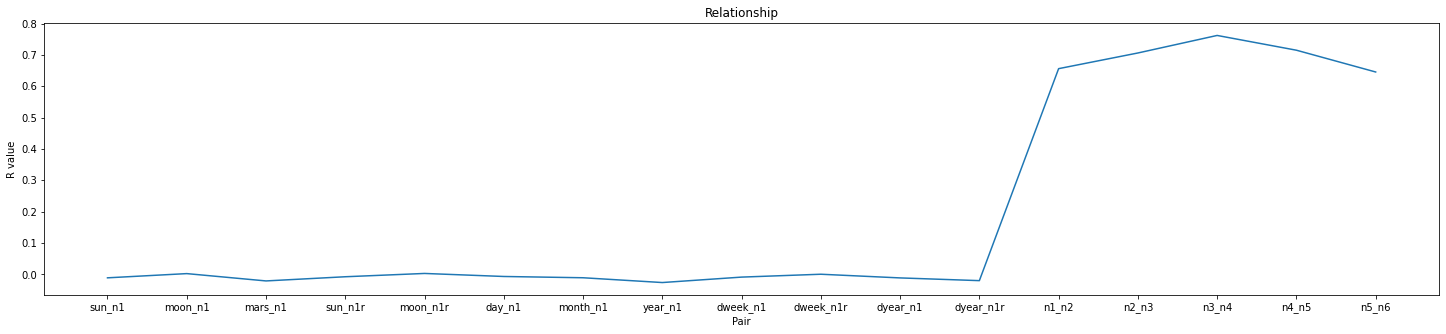

In [6]:
# define relationship pairs to check
relations = {
    'sun_n1': ['dist_sun_au', 'n1'],
    'moon_n1': ['dist_moon_au', 'n1'],
    'mars_n1': ['dist_mars_au', 'n1'],
    'sun_n1r': ['dist_sun_au', 'n1r'],
    'moon_n1r': ['dist_moon_au', 'n1r'],
    'day_n1': ['day', 'n1'],
    'month_n1': ['month', 'n1'],
    'year_n1': ['year', 'n1'],
    'dweek_n1': ['day_of_week', 'n1'],
    'dweek_n1r': ['day_of_week', 'n1r'],
    'dyear_n1': ['day_of_year', 'n1'],
    'dyear_n1r': ['day_of_year', 'n1r'],
    'n1_n2': ['n1', 'n2'],
    'n2_n3': ['n2', 'n3'],
    'n3_n4': ['n3', 'n4'],
    'n4_n5': ['n4', 'n5'],
    'n5_n6': ['n5', 'n6']
}

# calculate linear regression relationship between fields
print("[R] - linear regression relationship:\n")
rX = []
rY = []
for name, item in relations.items():
    x1 = item[0]
    x2 = item[1]
    if x1 in df and x2 in df:
        slope, intercept, r, p, std_err = linregress(df[x1], df[x2])        
        rX.append(name)
        rY.append(r)
        print(x1+' > '+x2+': ' + str(r))
    
# display relationships on plot
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(25)
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Relationship')
ax.set_xlabel('Pair')
ax.set_ylabel('R value')
ax.plot(rX, rY)
plt.show()

**6. Distributions of the frequency of occurrence of numbers in particular positions.**

The following cell displays the frequency distribution of the given numbers by their position.

Distributions of the frequency of occurrence of numbers in particular positions:


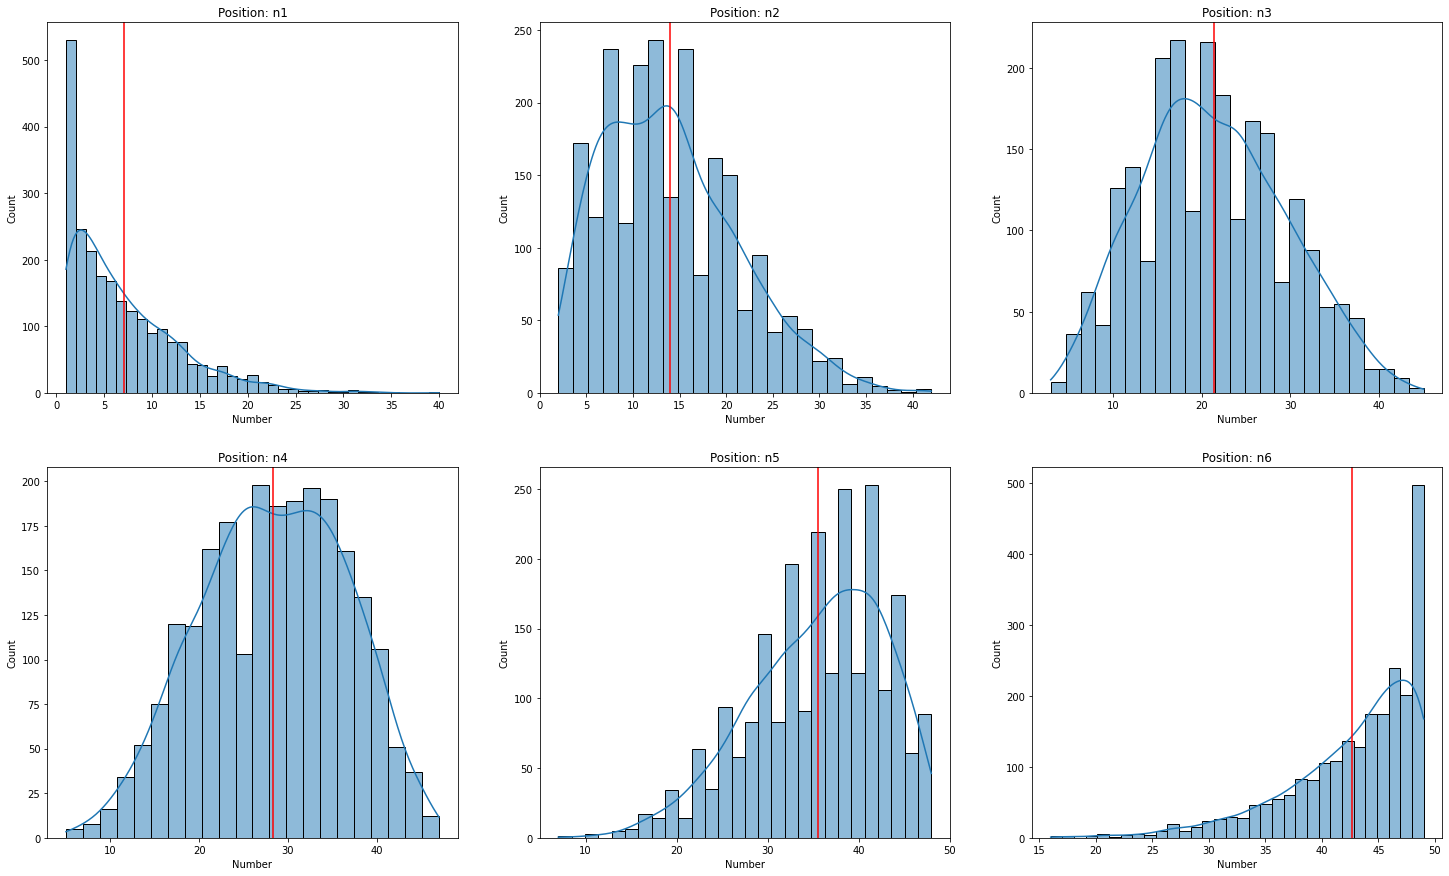

In [7]:
print('Distributions of the frequency of occurrence of numbers in particular positions:')

num_of_numbers = cfg['n_count']
cols = 3
rows = math.ceil(num_of_numbers/cols)
row = 0
col = 0
f, ax = plt.subplots(rows, cols, figsize=(25, 15))
for i in range(1, num_of_numbers+1):
    idx = 'n' + str(i)
    data = df[idx].to_numpy()
    sns.histplot(data, kde=True, ax=ax[row][col])
    ax[row][col].set_title('Position: '+idx)
    ax[row][col].set_xlabel('Number')
    ax[row][col].set_ylabel('Count')
    ax[row][col].axvline(x=data.mean(), color='red')
    if col >= (cols - 1):
        col = 0
        row+=1
    else:
        col+= 1
        
plt.show()

**7. Display a dataset.**

The cell below displays the extended data set prepared in the previous steps.

In [8]:
# display dataset
print("[DATASET]\n")
print(df.to_string())

[DATASET]

       idx        date  n1  n2  n3  n4  n5  n6  year  month  day  day_of_week  day_of_year  dist_moon_au  dist_sun_au  dist_mars_au  n1r  n2r  n3r  n4r  n5r
4424  4425  01.09.2007   5  15  21  25  26  40  2007      9    1            6          244      0.002442     1.009280      1.147736    0    1    2    2    2
4425  4426  04.09.2007   5  26  31  35  39  47  2007      9    4            2          247      0.002496     1.008576      1.130016    0    2    3    3    3
4426  4427  06.09.2007   3  11  21  35  45  48  2007      9    6            4          249      0.002544     1.008094      1.118094    0    1    2    3    4
4427  4428  08.09.2007   4   6  15  27  28  43  2007      9    8            6          251      0.002592     1.007599      1.106087    0    0    1    2    2
4428  4429  11.09.2007   4  16  21  35  43  47  2007      9   11            2          254      0.002658     1.006832      1.087926    0    1    2    3    4
4429  4430  13.09.2007  11  15  18  22  30  39 